# Test Model

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset, default_augmentation_pipeline
from model.training_loop import train, EarlyStoppingParams
from model.multimodal_har_model import MultiModalHARModel

Loading config...
Loading secrets...


2025-12-07 22:42:52,057 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2025-12-07 22:42:52,058 - INFO - Sentry initialized with environment: development


In [2]:
OBSERVATION_RATIO = 20
EAR_RATIO = OBSERVATION_RATIO / 100
WITH_OBJECT_BRANCH = False

## Initializing Training

**Creating Dataloaders**

In [3]:
TRAIN_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "train"
)
TEST_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "test"
)


train_video_data_loader = VideoDataLoader(
    path=TRAIN_DIR,
)
test_video_data_loader = VideoDataLoader(
    path=TEST_DIR,
)


train_dataset = VideoDataset(
    video_data_loader=train_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
    # transform=default_augmentation_pipeline(target_len=16, noise_std=0.02),
)
test_dataset = VideoDataset(
    video_data_loader=test_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
)


len(train_dataset)
for _ in train_dataset:
    pass
len(train_dataset.labels_map)

len(test_dataset)
for _ in test_dataset:
    pass


display(len(test_dataset.labels_map))
display(len(train_dataset.labels_map))

2025-12-07 22:42:54,037 - INFO - [VideoDataLoader] Loding action videos for action: 0_safe_walkway_violation
2025-12-07 22:42:54,603 - INFO - [VideoDataLoader] Loding action videos for action: 1_unauthorized_intervention
2025-12-07 22:42:54,947 - INFO - [VideoDataLoader] Loding action videos for action: 2_opened_panel cover
2025-12-07 22:42:55,280 - INFO - [VideoDataLoader] Loding action videos for action: 3_carrying_overload_with_forklift
2025-12-07 22:42:55,373 - INFO - [VideoDataLoader] Loding action videos for action: 4_safe_walkway
2025-12-07 22:42:55,490 - INFO - [VideoDataLoader] Loding action videos for action: 5_authorized_intervention
2025-12-07 22:42:55,799 - INFO - [VideoDataLoader] Loding action videos for action: 6_closed_panel_cover
2025-12-07 22:42:55,851 - INFO - [VideoDataLoader] Loding action videos for action: 7_safe_carrying
2025-12-07 22:42:56,674 - INFO - [VideoDataLoader] Loding action videos for action: 0_safe_walkway_violation
2025-12-07 22:42:56,780 - INFO - 

8

8

**Splitting Train and Test Datasets**

In [4]:
# num_total = len(train_dataset)
# num_train = int(0.8 * num_total)
# num_test = num_total - num_train
# train_dataset, test_dataset = random_split(train_dataset, [num_train, num_test])

**Creating Model**

In [5]:

attn_heads = 4
hidden_size = 192

assert hidden_size % attn_heads == 0, "Hidden size must be divisible by number of attention heads."

har_model = MultiModalHARModel(
    obj_in=train_dataset[0].graphs_objects[0].x.shape[1],
    joint_in=train_dataset[0].graphs_joints[0].x.shape[1],
    gat_hidden=hidden_size,
    gat_out=hidden_size,
    temporal_hidden=hidden_size,
    num_classes=len(train_dataset.labels_map), 
    dropout=0.1,
    temporal_pooling="attn_pool",
    attention_pooling_heads=attn_heads,
    temporal_transformer_heads=attn_heads,
    use_layer_norm=True,
    use_object_branch=WITH_OBJECT_BRANCH, # Testing without object branch
)

2025-12-07 22:42:57,536 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': False, 'device': 'cpu'}


**Create Evaluate Function For Early Stopping**

In [6]:
import torch
from validation.quantitative_metrics import evaluate_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model_with_auc(model, dataset):
    return evaluate_model(model, dataset, device).accuracy

def evaluate(model, dataset):
    import torch
    device = 'cpu'
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            label = sample.label.to(device)

            # Move all graph tensors to device
            graphs_objects = [g.to(device) for g in sample.graphs_objects]
            graphs_joints = [g.to(device) for g in sample.graphs_joints]

            # Forward pass
            output = model(graphs_objects, graphs_joints)

            # Compute prediction
            if output.dim() == 1:
                predicted = torch.argmax(output).unsqueeze(0)
            else:
                _, predicted = torch.max(output, dim=1)

            correct += (predicted == label).sum().item()
            total += 1

    accuracy = 100 * correct / total
    return accuracy


In [7]:
early_stopping_params = EarlyStoppingParams(
    patience=20,
    min_delta=1e-4,
    mode='max',
    evaluation_function=evaluate_model_with_auc,
    evaluation_dataset=test_dataset,
)

In [8]:
from model.training_loop import WarmupSchedulerParams


train_history = train(
    model=har_model,
    video_dataset=train_dataset,
    device='cpu',
    # epochs=120,
    epochs=40,
    # epochs=90,
    lr=1e-4,
    weight_decay=1e-4,
    # early_stopping=early_stopping_params,
    warmup_scheduler_params=WarmupSchedulerParams(True, 400),
    cross_entropy_label_smoothing=0.1,
)

2025-12-07 22:42:58,900 - INFO - Starting training loop...
2025-12-07 22:42:58,903 - INFO - Using weight decay: 0.0001
2025-12-07 22:42:58,903 - INFO - Using Label Smoothing Cross Entropy with smoothing=0.1
Epoch 1/40:   0%|          | 0/566 [00:00<?, ?it/s]/Users/guilhermeleonardonunes/temp/masters-implementation/model/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 1/40: 100%|██████████| 566/566 [00:10<00:00, 55.18it/s]
2025-12-07 22:43:09,174 - INFO - Epoch 1/40, Loss: 1.8086
Epoch 2/40: 100%|██████████| 566/566 [00:10<00:00, 53.95it/s]
2025-12-07 22:43:19,66

## Training Model

**Early Stopping**

**Training**

**Saving Model**

In [9]:
har_model.save(
    training_history=train_history,
    EAR_ratio=EAR_RATIO,
    with_object_branch=WITH_OBJECT_BRANCH,
)

2025-12-07 22:49:59,991 - INFO - Saving model to /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_20_no_obj_20251207_224959.pht...
2025-12-07 22:50:00,195 - INFO - Model saved successfully.


## Running tests

**Accuracy**

In [10]:
accuracy_evaluation = evaluate(har_model, test_dataset)
print(f"Test Accuracy: {accuracy_evaluation:.2f}%")

Test Accuracy: 28.80%


## Debugging

In [11]:
import torch, torch.nn.functional as F
device = 'cpu'   # match training device
har_model.to(device)
har_model.eval()

sample = train_dataset[0]
graphs_objects = [g.to(device) for g in sample.graphs_objects]
graphs_joints = [g.to(device) for g in sample.graphs_joints]
label = sample.label.unsqueeze(0).to(device)

with torch.no_grad():
    out = har_model(graphs_objects, graphs_joints)   # expect [1, num_classes]
    probs = F.softmax(out, dim=-1)
    ent = -(probs * probs.log()).sum(dim=-1)     # entropy
    pred = torch.argmax(probs, dim=-1)

print("out.shape", out.shape)
print("out device", out.device, "label device", label.device)
print("logits:", out.cpu().numpy())
print("probs:", probs.cpu().numpy())
print("entropy:", ent.item())
print("pred:", pred.item(), "label:", label.item())


out.shape torch.Size([1, 8])
out device cpu label device cpu
logits: [[ 3.467797   -1.3171194   0.9985336  -0.15972127 -2.914488   -2.6006227
  -1.9869895  -2.2455745 ]]
probs: [[0.88404244 0.00738602 0.0748317  0.02349968 0.00149514 0.00204641
  0.00377998 0.00291869]]
entropy: 0.48787176609039307
pred: 0 label: 0


**Mapping Consistency - Distribution**

In [12]:
from collections import Counter
def inspect_dataset(dataset, name):
    labels = [int(s.label) for s in dataset]
    print(f"=== {name} ===")
    print("len:", len(labels))
    print("unique labels:", sorted(set(labels)))
    print("counts:", Counter(labels))
    print("labels_map (sample):", getattr(dataset, "labels_map", None))
    print()

inspect_dataset(train_dataset, "TRAIN")
inspect_dataset(test_dataset, "TEST")


=== TRAIN ===
len: 566
unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
counts: Counter({0: 178, 2: 129, 1: 97, 4: 50, 3: 48, 5: 23, 7: 22, 6: 19})
labels_map (sample): {'0_safe_walkway_violation': 0, '1_unauthorized_intervention': 1, '2_opened_panel cover': 2, '3_carrying_overload_with_forklift': 3, '4_safe_walkway': 4, '5_authorized_intervention': 5, '6_closed_panel_cover': 6, '7_safe_carrying': 7}

=== TEST ===
len: 125
unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
counts: Counter({0: 32, 4: 25, 5: 15, 2: 13, 6: 13, 1: 11, 3: 8, 7: 8})
labels_map (sample): {'0_safe_walkway_violation': 0, '1_unauthorized_intervention': 1, '2_opened_panel cover': 2, '3_carrying_overload_with_forklift': 3, '4_safe_walkway': 4, '5_authorized_intervention': 5, '6_closed_panel_cover': 6, '7_safe_carrying': 7}



**Prediction Distribution - Predicts only few classes**

In [13]:
from collections import Counter
import torch, torch.nn.functional as F

def pred_distribution(model, dataset, device='cpu'):
    model.eval()
    preds = []
    truths = []
    with torch.no_grad():
        for s in dataset:
            graphs_objects = [g.to(device) for g in s.graphs_objects]
            graphs_joints  = [g.to(device) for g in s.graphs_joints]
            out = model(graphs_objects, graphs_joints)  # [1, C]
            preds.append(int(torch.argmax(out, dim=-1)))
            truths.append(int(s.label))
    print("pred distribution:", Counter(preds))
    print("true distribution :", Counter(truths))
    return preds, truths

preds, truths = pred_distribution(har_model, test_dataset, device='cpu')


pred distribution: Counter({2: 34, 0: 30, 1: 21, 4: 19, 3: 14, 5: 5, 7: 1, 6: 1})
true distribution : Counter({0: 32, 4: 25, 5: 15, 2: 13, 6: 13, 1: 11, 3: 8, 7: 8})


**Confusion Matrix - Per Class Prediction**

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(truths, preds)
print("Confusion matrix:\n", cm)
print(classification_report(truths, preds, digits=4))


Confusion matrix:
 [[11 11  0  1  8  1  0  0]
 [ 4  5  0  0  1  1  0  0]
 [ 2  0  8  2  1  0  0  0]
 [ 3  0  1  4  0  0  0  0]
 [ 6  3  7  2  5  1  0  1]
 [ 1  2  7  0  3  2  0  0]
 [ 1  0  8  2  1  0  1  0]
 [ 2  0  3  3  0  0  0  0]]
              precision    recall  f1-score   support

           0     0.3667    0.3438    0.3548        32
           1     0.2381    0.4545    0.3125        11
           2     0.2353    0.6154    0.3404        13
           3     0.2857    0.5000    0.3636         8
           4     0.2632    0.2000    0.2273        25
           5     0.4000    0.1333    0.2000        15
           6     1.0000    0.0769    0.1429        13
           7     0.0000    0.0000    0.0000         8

    accuracy                         0.2880       125
   macro avg     0.3486    0.2905    0.2427       125
weighted avg     0.3622    0.2880    0.2613       125



**Confusion Matrix**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, class_names, normalize=True, figsize=(10, 8), cmap="Blues"):
    """
    Visual, attractive confusion matrix with optional normalization.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # handle div-by-zero

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap=cmap,
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        annot_kws={"size": 12, "weight": "bold"}
    )

    plt.title("Confusion Matrix", fontsize=18, weight="bold")
    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

    plt.tight_layout()
    plt.show()


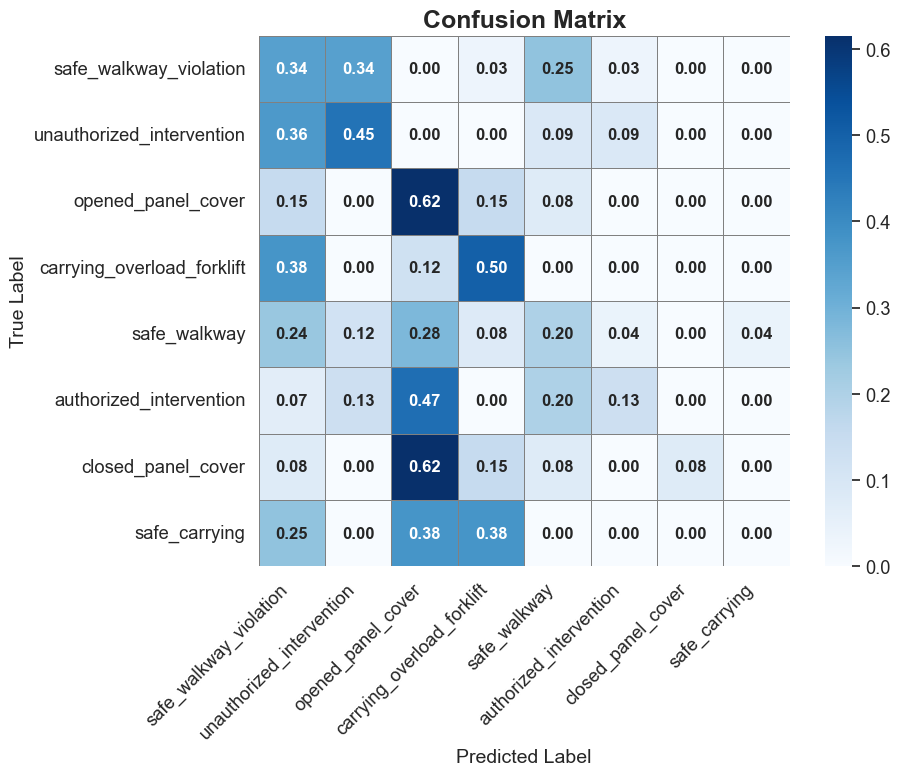

In [16]:
class_names = [
    "safe_walkway_violation",
    "unauthorized_intervention",
    "opened_panel_cover",
    "carrying_overload_forklift",
    "safe_walkway",
    "authorized_intervention",
    "closed_panel_cover",
    "safe_carrying"
]

plot_confusion_matrix(cm, class_names, normalize=True)
